# Lab08 - Clustering

## Datasets import

In [1]:
!curl -L https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/2D_gauss_clusters.txt -o gauss_clusters.csv
!curl -L https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/chameleon_clusters.txt -o chameleon_clusters.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70004  100 70004    0     0   335k      0 --:--:-- --:--:-- --:--:--  335k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  168k  100  168k    0     0   879k      0 --:--:-- --:--:-- --:--:--  884k


## K-means design and implementation

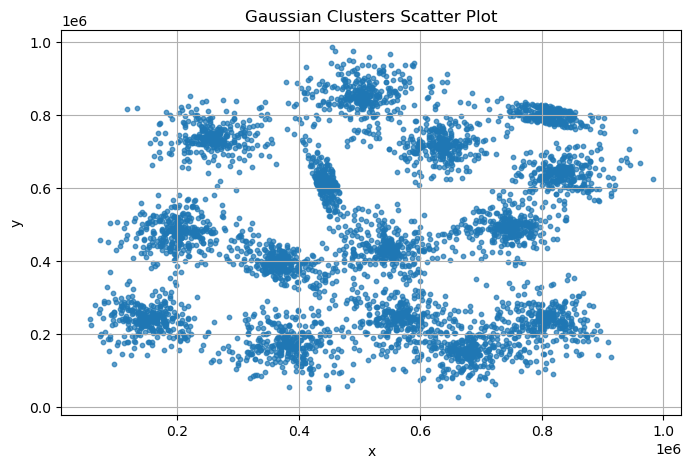

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
gauss_data = pd.read_csv("gauss_clusters.csv")
chameleon_data = pd.read_csv('chameleon_clusters.csv')

plt.figure(figsize=(8, 5))
plt.scatter(gauss_data['x'], gauss_data['y'], s=10, alpha=0.7)
plt.title('Gaussian Clusters Scatter Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [3]:
import numpy as np

class KMeans:
    def __init__(self, n_clusters, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.labels = None
    
    def fit_predict(self, X):
        X = np.array(X, dtype=np.float64)
        if X.ndim != 2:
            raise ValueError("X must be 2D array")
        
        n_samples, n_features = X.shape
        if n_samples < self.n_clusters:
            raise ValueError("n_samples should be >= n_clusters")
        
        idx = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[idx].copy()
        
        for iteration in range(self.max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels = np.argmin(distances, axis=1)

            new_centroids = np.array([X[self.labels == k].mean(axis=0) if np.sum(self.labels == k) > 0 else self.centroids[k]for k in range(self.n_clusters)])
            
            if np.allclose(self.centroids, new_centroids):
                break
                
            self.centroids = new_centroids
        
        return self.labels


In [4]:
X_gauss = gauss_data.values
X_chameleon = chameleon_data.values

k_values = [5, 10, 15, 20]

for k in k_values:
    kmeans_gauss = KMeans(n_clusters=k, max_iter=100)
    labels_gauss = kmeans_gauss.fit_predict(X_gauss)
    
    kmeans_chameleon = KMeans(n_clusters=k, max_iter=100)
    labels_chameleon = kmeans_chameleon.fit_predict(X_chameleon)
    
    print(f"K={k}: Gauss labels shape={labels_gauss.shape}, Chameleon labels shape={labels_chameleon.shape}")

K=5: Gauss labels shape=(5000,), Chameleon labels shape=(8000,)
K=10: Gauss labels shape=(5000,), Chameleon labels shape=(8000,)
K=15: Gauss labels shape=(5000,), Chameleon labels shape=(8000,)
K=20: Gauss labels shape=(5000,), Chameleon labels shape=(8000,)


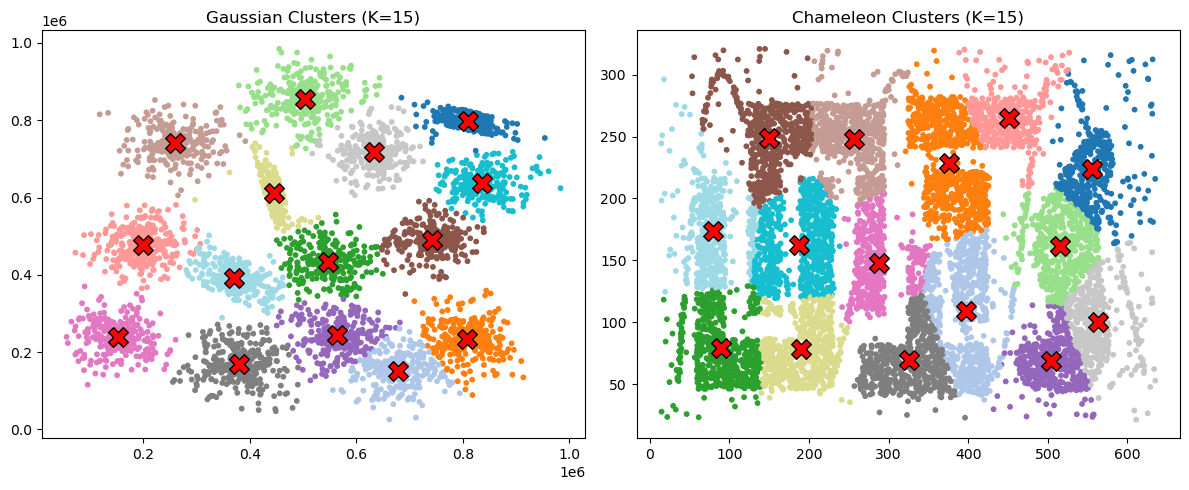

In [5]:
kmeans_g = KMeans(n_clusters=15, max_iter=100)
labels_g = kmeans_g.fit_predict(X_gauss)

kmeans_c = KMeans(n_clusters=15, max_iter=100)
labels_c = kmeans_c.fit_predict(X_chameleon)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(X_gauss[:, 0], X_gauss[:, 1], c=labels_g, cmap='tab20', s=10)
ax1.scatter(kmeans_g.centroids[:, 0], kmeans_g.centroids[:, 1], c='red', marker='X', s=200, edgecolors='black')
ax1.set_title('Gaussian Clusters (K=15)')

ax2.scatter(X_chameleon[:, 0], X_chameleon[:, 1], c=labels_c, cmap='tab20', s=10)
ax2.scatter(kmeans_c.centroids[:, 0], kmeans_c.centroids[:, 1],c='red', marker='X', s=200, edgecolors='black')
ax2.set_title('Chameleon Clusters (K=15)')

plt.tight_layout()
plt.show()

## Evaluate clustering performance

In [6]:
def silhouette_samples(X, labels):
    X = np.asarray(X, dtype=float)
    labels = np.asarray(labels)
    N = X.shape[0]

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    if n_clusters < 2:
        return np.zeros(N, dtype=float)

    D = np.zeros((N, N), dtype=float)
    for i in range(N):
        diff = X - X[i]           
        D[i] = np.sqrt(np.sum(diff**2, axis=1))

    silhouettes = np.zeros(N, dtype=float)

    for i in range(N):
        label_i = labels[i]
        same_cluster = (labels == label_i)
        same_cluster[i] = False  

        if np.any(same_cluster):
            a_i = D[i, same_cluster].mean()
        else:
            silhouettes[i] = 0.0
            continue

        b_i = np.inf
        for other_label in unique_labels:
            if other_label == label_i:
                continue
            other_cluster = (labels == other_label)
            if np.any(other_cluster):
                mean_dist = D[i, other_cluster].mean()
                if mean_dist < b_i:
                    b_i = mean_dist

        denom = max(a_i, b_i)
        if denom > 0:
            silhouettes[i] = (b_i - a_i) / denom
        else:
            silhouettes[i] = 0.0

    return silhouettes


def silhouette_score(X, labels):
    s = silhouette_samples(X, labels)
    return float(np.mean(s))

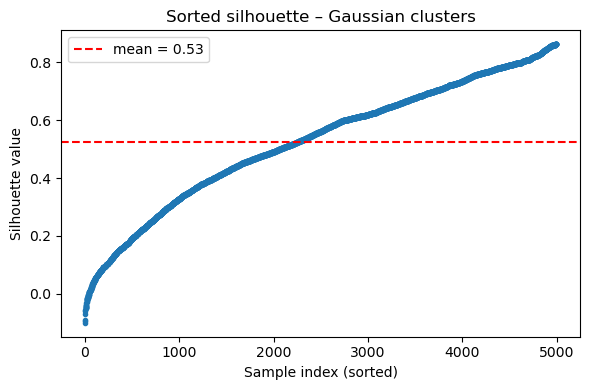

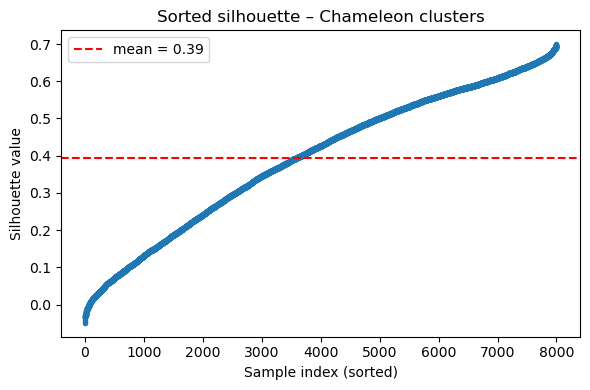

In [7]:
def plot_sorted_silhouette(X, labels, title=None):
    s = silhouette_samples(X, labels)  
    s_sorted = np.sort(s)             

    plt.figure(figsize=(6, 4))
    plt.plot(s_sorted, marker='.', linestyle='none')
    plt.axhline(y=np.mean(s_sorted), color='red', linestyle='--',
                label=f"mean = {np.mean(s_sorted):.2f}")
    plt.ylabel("Silhouette value")
    plt.xlabel("Sample index (sorted)")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

labels_gauss = kmeans_g.fit_predict(X_gauss)
labels_cham  = kmeans_c.fit_predict(X_chameleon)

plot_sorted_silhouette(X_gauss, labels_gauss,title="Sorted silhouette – Gaussian clusters")
plot_sorted_silhouette(X_chameleon, labels_cham,title="Sorted silhouette – Chameleon clusters")

## Newsgroups clustering

In [8]:
import os
import urllib.request
import zipfile

url = "https://github.com/dbdmg/data-science-lab/blob/master/datasets/T-newsgroups.zip?raw=true"
zip_path = "T-newsgroups.zip"

print("Downloading dataset...")
urllib.request.urlretrieve(url, zip_path)
print("Download completed.")

extract_dir = "T-newsgroups"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("Extraction completed.")


Download completed.
Extraction completed.


In [9]:
documents = []

for root, dirs, files in os.walk(extract_dir):
    for fname in files:
        fullpath = os.path.join(root, fname)
        with open(fullpath, "r", encoding="latin1", errors="ignore") as f:
            documents.append(f.read())

print(f"Number of documents loaded: {len(documents)}")


Number of documents loaded: 8001


In [10]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
from sklearn.feature_extraction.text import TfidfVectorizer


class LemmaTokenizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, document):
        return [self.lemmatizer.lemmatize(t.strip().lower()) 
                for t in word_tokenize(document)]

lemmaTokenizer = LemmaTokenizer()


vectorizer = TfidfVectorizer(
    tokenizer=lemmaTokenizer,
    stop_words=sw.words('english')
)

tfidf_X = vectorizer.fit_transform(documents)
print("TF-IDF matrix shape:", tfidf_X.shape)

/Users/giorgiozoccatelli/miniforge3/envs/data/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/giorgiozoccatelli/miniforge3/envs/data/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(


TF-IDF matrix shape: (8001, 55873)


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(tfidf_X)

sil_score = silhouette_score(tfidf_X, labels)
print(f"Silhouette score per k={k}: {sil_score:.4f}")

sse = kmeans.inertia_
print(f"Sum of Squared Errors (SSE) per k={k}: {sse:.2f}")

Silhouette score per k=20: 0.5144
Sum of Squared Errors (SSE) per k=20: 2904.55


## Word Clouds and Itemset Mining

In [12]:
!pip install wordcloud

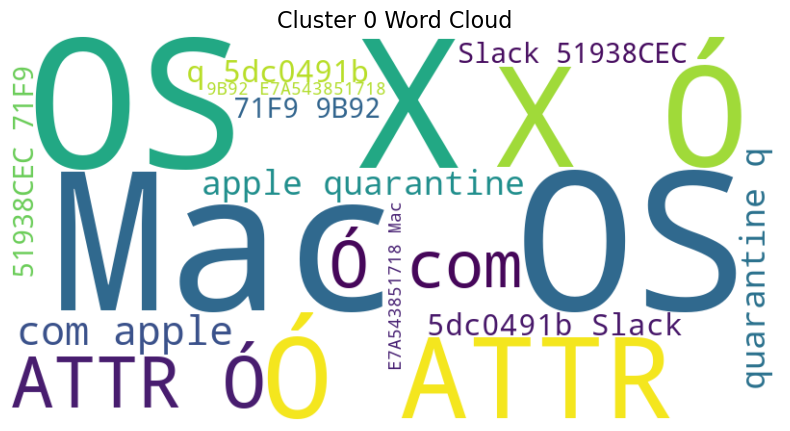

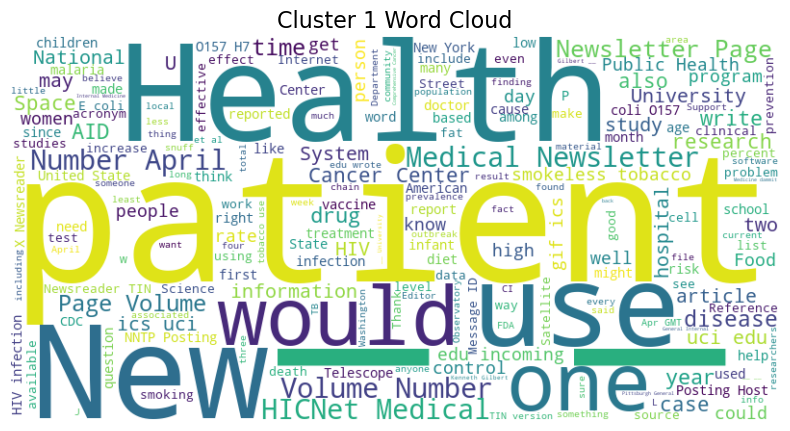

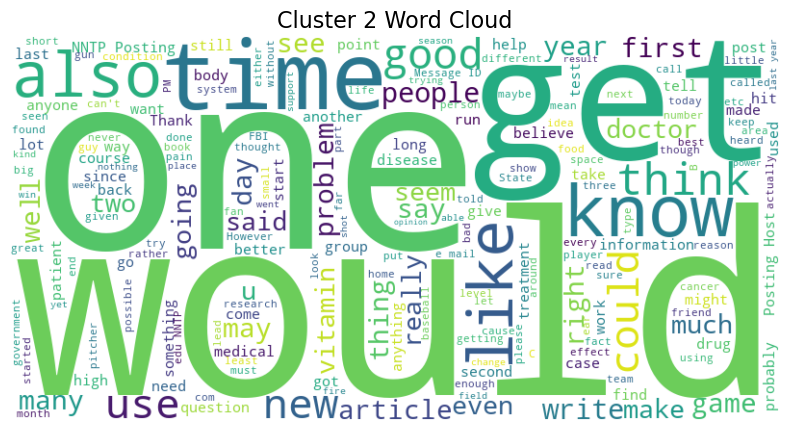

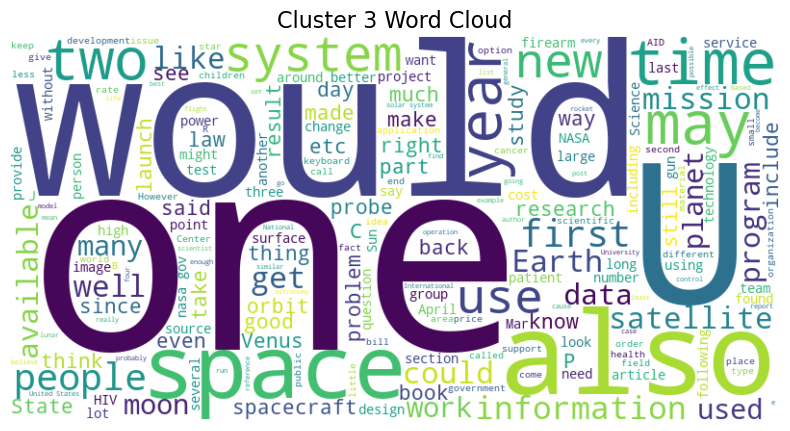

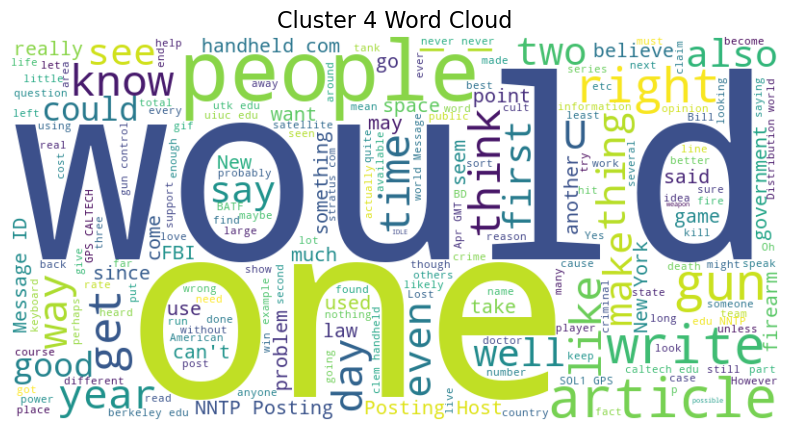

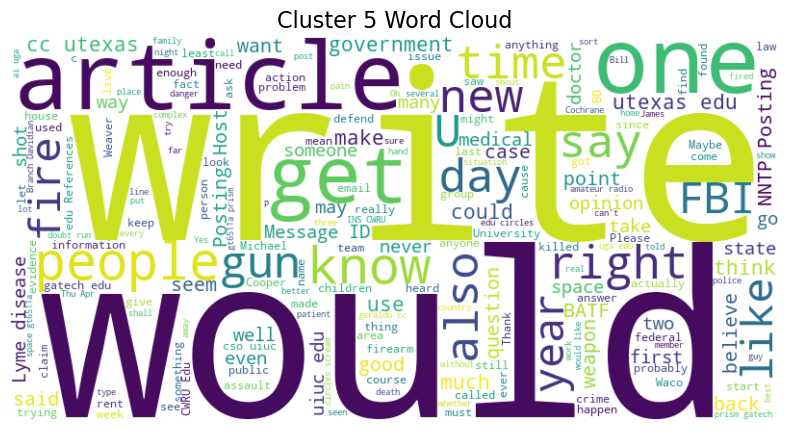

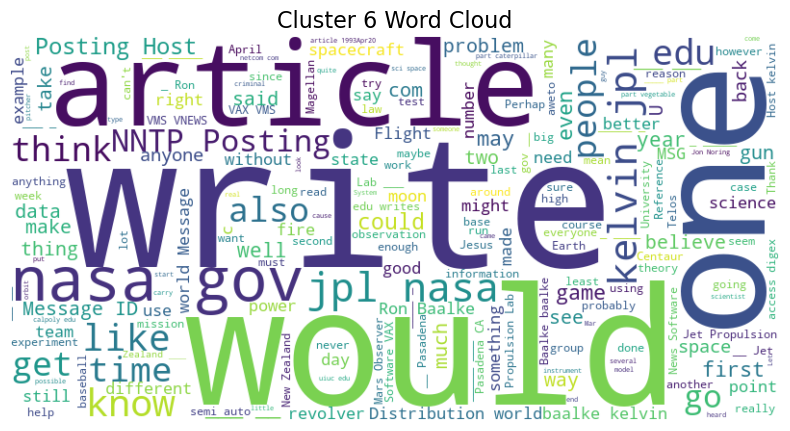

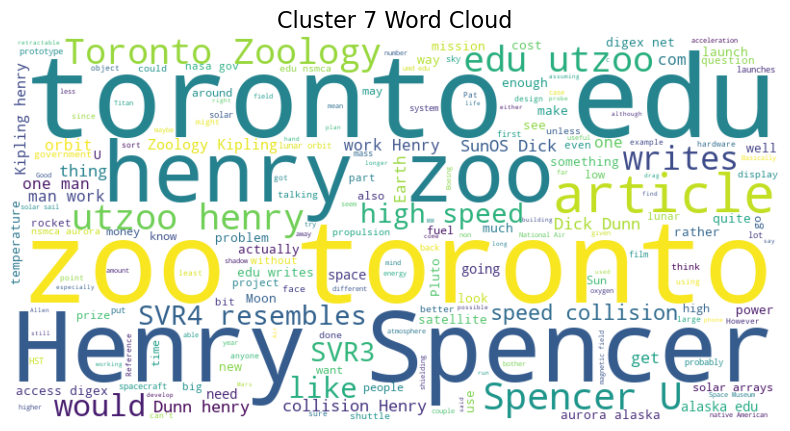

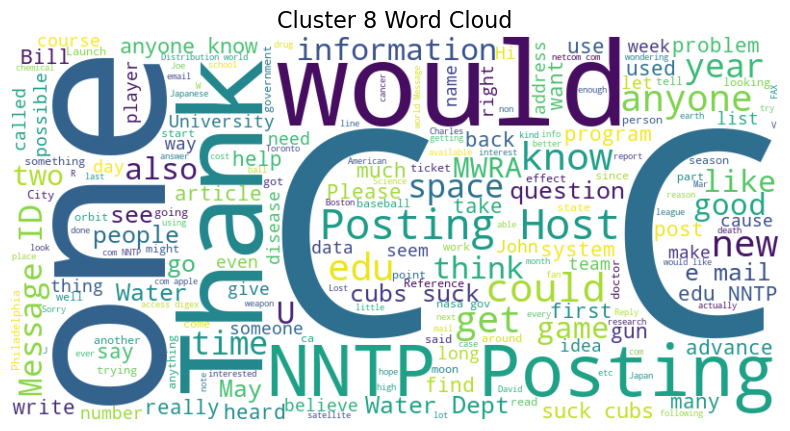

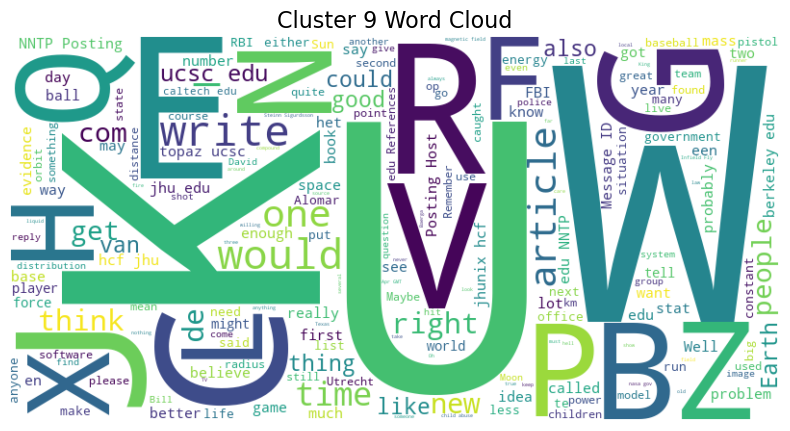

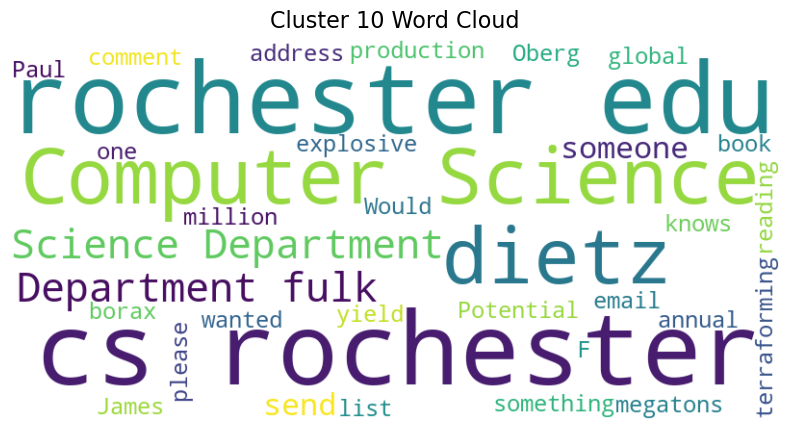

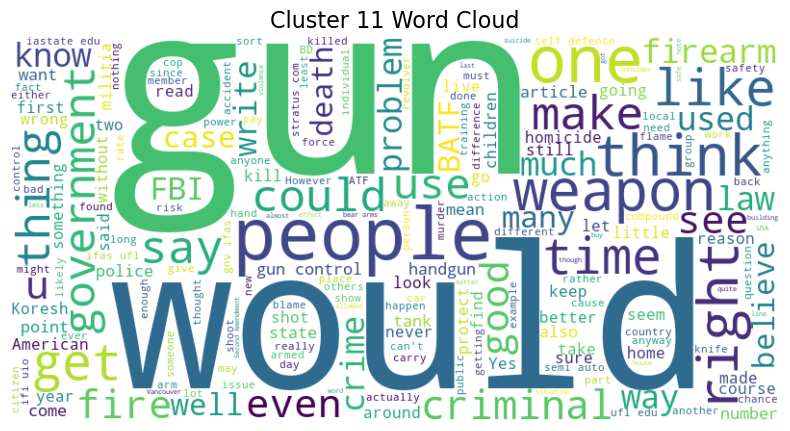

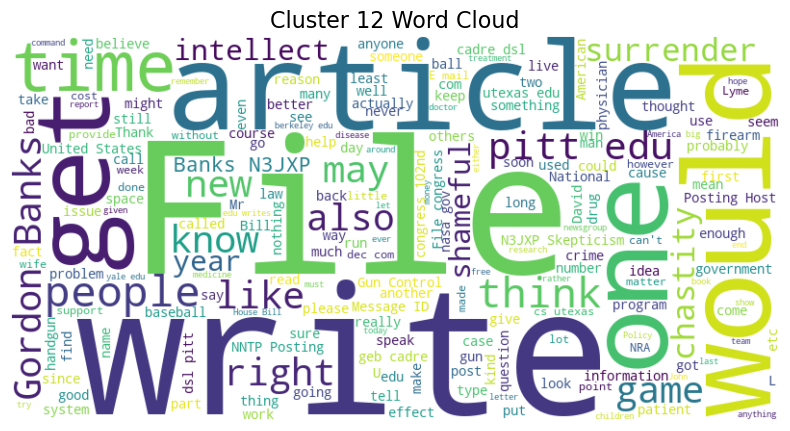

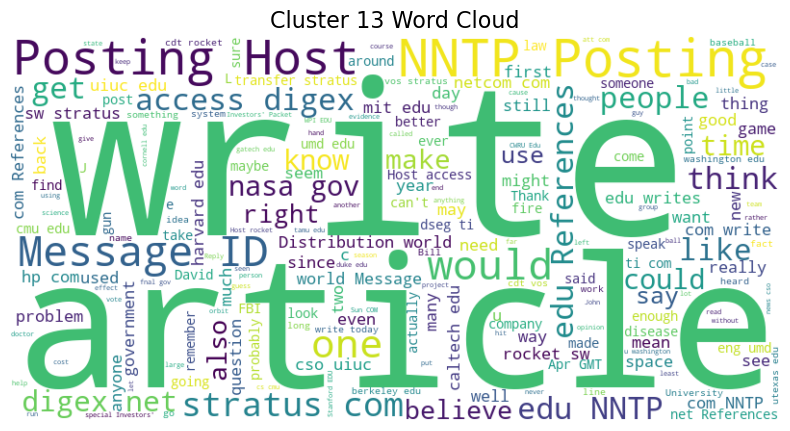

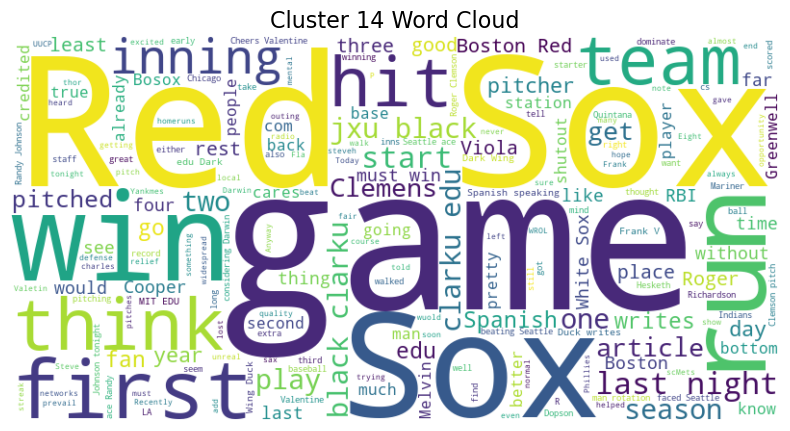

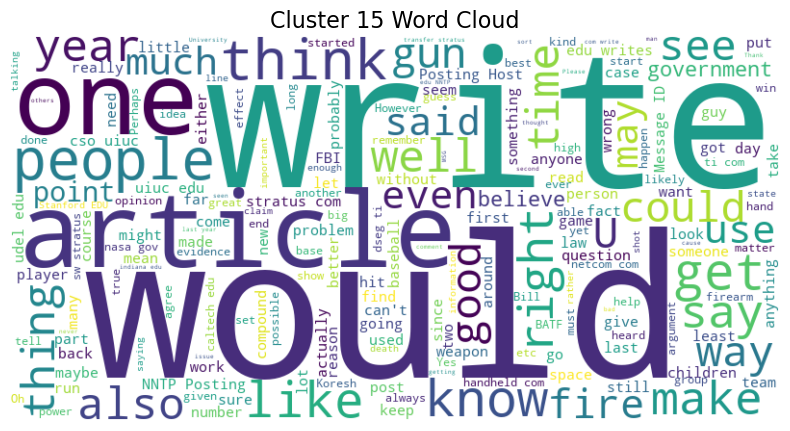

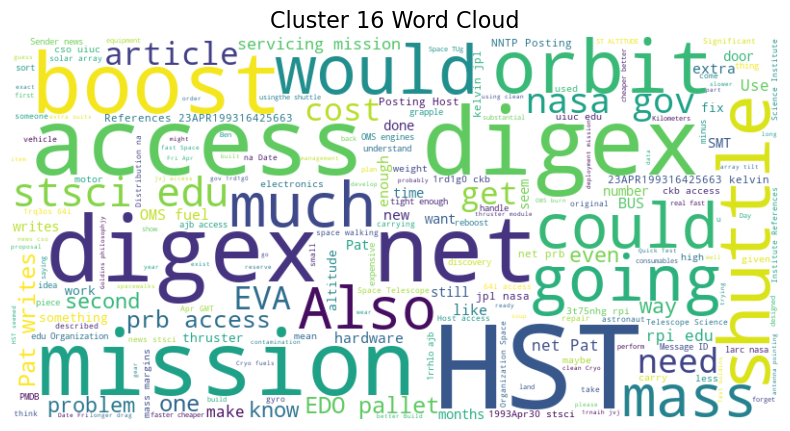

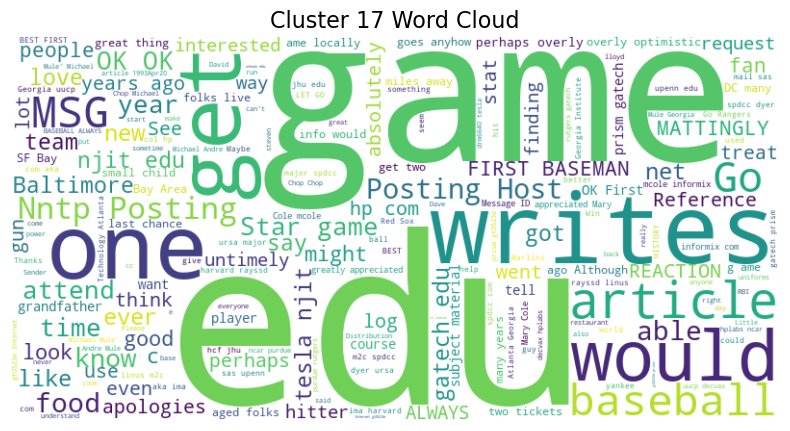

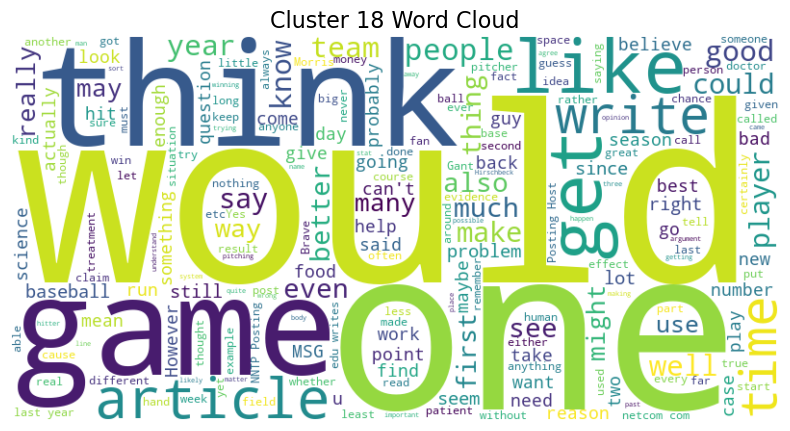

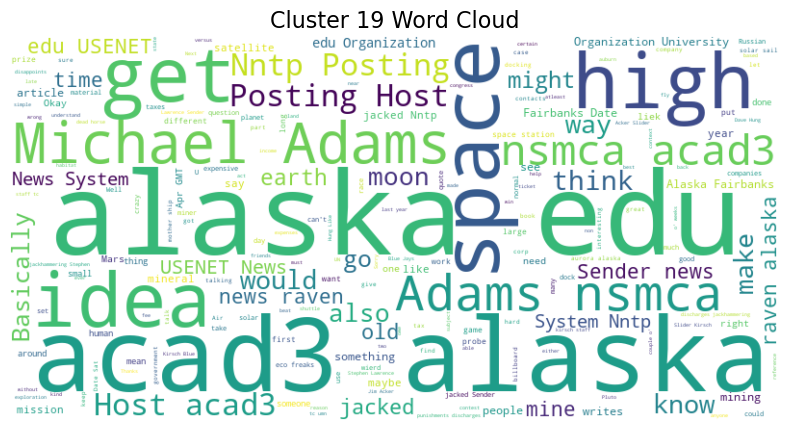

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

k = len(np.unique(labels))

for cluster_id in range(k):
    cluster_docs = [documents[i] for i in range(len(documents)) if labels[i] == cluster_id]
    
    text = " ".join(cluster_docs)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=sw.words('english')).generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_id} Word Cloud', fontsize=16)
    plt.show()


In [14]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from collections import Counter

stop_words = set(sw.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_doc(doc):
    tokens = [lemmatizer.lemmatize(t.lower()) 
              for t in word_tokenize(doc) 
              if t.isalpha() and t.lower() not in stop_words]
    return tokens

k = len(set(labels))

for cluster_id in range(k):
    print(f"\n--- Cluster {cluster_id} ---")
    
    cluster_docs = [documents[i] for i in range(len(documents)) if labels[i] == cluster_id]
    
    all_tokens = []
    transactions = []
    for doc in cluster_docs:
        tokens = preprocess_doc(doc)
        transactions.append(tokens)
        all_tokens.extend(tokens)
    
    word_freq = Counter(all_tokens)
    top_words = [word for word, freq in word_freq.most_common(300)]
    
    filtered_transactions = [[w for w in trans if w in top_words] for trans in transactions]
    
    te = TransactionEncoder()
    te_ary = te.fit(filtered_transactions).transform(filtered_transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    
    frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True, max_len=3)
    
    frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
    print(frequent_itemsets.head(10))


--- Cluster 0 ---
   support       itemsets
0      1.0            (o)
1      1.0        (slack)
2      1.0            (x)
3      1.0     (slack, o)
4      1.0         (o, x)
5      1.0     (slack, x)
6      1.0  (slack, o, x)

--- Cluster 1 ---
     support      itemsets
22  0.427184       (would)
23  0.417476      (writes)
13  0.378641         (one)
24  0.368932       (wrote)
16  0.349515        (time)
1   0.339806     (article)
20  0.320388  (university)
5   0.291262     (general)
7   0.291262        (know)
11  0.271845         (new)

--- Cluster 2 ---
     support   itemsets
10  0.385813    (would)
7   0.351211      (one)
6   0.320069     (like)
5   0.304498     (know)
9   0.299308     (time)
11  0.288927   (writes)
0   0.261246     (also)
3   0.254325      (get)
12  0.249135     (year)
1   0.240484  (article)

--- Cluster 3 ---
      support      itemsets
87   0.657754         (one)
146  0.652406       (would)
131  0.561497        (time)
1    0.529412        (also)
72   0.508021  

## Anomaly Detection on the MNIST Dataset

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

transform = transforms.Compose([
    transforms.ToTensor(),          
    transforms.Lambda(lambda x: x.view(-1))  
])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

X = mnist_train.data.view(-1, 784).float() / 255.0   
y = mnist_train.targets

print("MNIST shape:", X.shape)

MNIST shape: torch.Size([60000, 784])


In [16]:
def add_salt_and_pepper(x, amount=0.3):
    noisy = x.clone()
    mask = torch.rand_like(noisy)
    noisy[mask < amount/2] = 0.0     
    noisy[mask > 1 - amount/2] = 1.0 
    return noisy


idx_point = torch.randperm(len(X))[:200]
X_point_anom = X.clone()
X_point_anom[idx_point] = add_salt_and_pepper(X[idx_point])

print("Point anomalies added:", len(idx_point))

Point anomalies added: 200


Epoch 1, Loss: 0.0369
Epoch 2, Loss: 0.0245
Epoch 3, Loss: 0.0180
Low-quality digits detected: 200


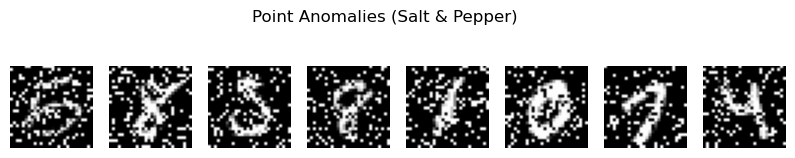

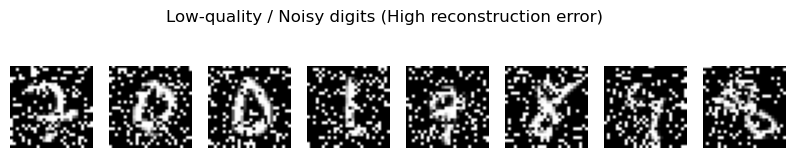

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

ae = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

loader = DataLoader(TensorDataset(X_point_anom), batch_size=256, shuffle=True)

for epoch in range(3):
    for (batch,) in loader:
        optimizer.zero_grad()
        recon = ae(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

with torch.no_grad():
    recon_all = ae(X_point_anom)
    errors = torch.mean((recon_all - X_point_anom)**2, dim=1)

k = 200
idx_low_quality = torch.topk(errors, k=k).indices

print("Low-quality digits detected:", len(idx_low_quality))

def show_samples(indices, title, n=8):
    plt.figure(figsize=(10,2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = X_point_anom[indices[i]].view(28,28)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(idx_point[:8], "Point Anomalies (Salt & Pepper)")
show_samples(idx_low_quality[:8], "Low-quality / Noisy digits (High reconstruction error)")


Collective anomalies shape: torch.Size([200, 784])
Normal samples: 59800
Total anomalies: 600
FINAL SHAPES
X_final: torch.Size([60400, 784])
y_final: torch.Size([60400])


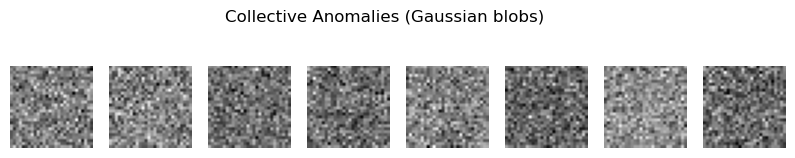

In [18]:
def generate_collective_anomalies(n_samples=200, img_size=28):
    mean = 0.5
    std = 0.08   
    
    imgs = np.random.normal(loc=mean, scale=std, size=(n_samples, img_size*img_size))
    imgs = np.clip(imgs, 0, 1)  
    return torch.tensor(imgs, dtype=torch.float32)

X_collective = generate_collective_anomalies(200)
print("Collective anomalies shape:", X_collective.shape)

normal_mask = torch.ones(len(X), dtype=torch.bool)

normal_mask[idx_point] = False
normal_mask[idx_low_quality] = False

X_normal = X[normal_mask]
print("Normal samples:", len(X_normal))

X_anomalies = torch.cat([
    X_point_anom[idx_point],     
    X_point_anom[idx_low_quality], 
    X_collective                
], dim=0)

print("Total anomalies:", len(X_anomalies))
X_final = torch.cat([X_normal, X_anomalies], dim=0)

y_final = torch.cat([
    torch.zeros(len(X_normal), dtype=torch.long),
    torch.ones(len(X_anomalies), dtype=torch.long)
], dim=0)

print("FINAL SHAPES")
print("X_final:", X_final.shape)
print("y_final:", y_final.shape)



plt.figure(figsize=(10,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_collective[i].view(28,28), cmap="gray")
    plt.axis("off")
plt.suptitle("Collective Anomalies (Gaussian blobs)")
plt.show()

In [19]:
from torch.utils.data import Subset
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


transform = transforms.ToTensor()
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

subset_idx = np.random.choice(len(mnist), 10000, replace=False)
mnist = Subset(mnist, subset_idx)

loader = DataLoader(mnist, batch_size=len(mnist))
imgs, labels = next(iter(loader))

X = imgs.view(len(mnist), -1).numpy()

def add_salt_pepper(x, amount=0.2):
    noisy = x.copy()
    num = int(amount * x.size)
    idx = np.random.choice(x.size, num, replace=False)
    noisy[idx] = np.random.choice([0.0, 1.0], size=num)
    return noisy

num_point = 50
point_idx = np.random.choice(len(X), num_point, replace=False)
X_point = np.array([add_salt_pepper(X[i], 0.25) for i in point_idx])

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(784, 64), nn.ReLU(), nn.Linear(64, 16))
        self.dec = nn.Sequential(nn.Linear(16, 64), nn.ReLU(), nn.Linear(64, 784), nn.Sigmoid())
    def forward(self, x):
        return self.dec(self.enc(x))

ae = AE()
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)

Xt = torch.tensor(X, dtype=torch.float32)

for _ in range(1):
    recon = ae(Xt)
    loss = ((recon - Xt)**2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

with torch.no_grad():
    recon = ae(Xt).numpy()

errors = ((recon - X)**2).mean(axis=1)

num_lowq = 80
lowq_idx = np.argsort(errors)[-num_lowq:]
X_lowq = X[lowq_idx]

num_blob = 80
X_blob = np.random.normal(loc=0.5, scale=0.05, size=(num_blob, 784))
X_blob = np.clip(X_blob, 0, 1)

X_anom = np.vstack([X_point, X_lowq, X_blob])
y_anom = np.ones(len(X_anom))

normal_mask = np.ones(len(X), dtype=bool)
normal_mask[point_idx] = False
normal_mask[lowq_idx] = False

X_norm = X[normal_mask]
y_norm = np.zeros(len(X_norm))

X_final = np.vstack([X_norm, X_anom])
y_final = np.hstack([y_norm, y_anom])

print("Dataset shape:", X_final.shape, "   anomalies:", y_final.sum())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(X_scaled)
score_lof = -lof.score_samples(X_scaled)   

iso = IsolationForest(n_estimators=50)
iso.fit(X_scaled)
score_iso = -iso.score_samples(X_scaled)

svm = OneClassSVM(kernel="rbf", gamma=0.01)
svm.fit(X_scaled)
score_svm = -svm.decision_function(X_scaled)

kmeans = KMeans(n_clusters=10, n_init=5)
kmeans.fit(X_scaled)
dist = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.predict(X_scaled)], axis=1)
score_kmeans = dist

score_ae = ((ae(torch.tensor(X_final, dtype=torch.float32)).detach().numpy() - X_final)**2).mean(axis=1)

print("Scores computed:")
print("LOF:", score_lof.shape)
print("IF:", score_iso.shape)
print("SVM:", score_svm.shape)
print("KMEANS:", score_kmeans.shape)
print("AE:", score_ae.shape)

Dataset shape: (10082, 784)    anomalies: 210.0
Scores computed:
LOF: (10082,)
IF: (10082,)
SVM: (10082,)
KMEANS: (10082,)
AE: (10082,)


In [21]:
k = int(y_anom.sum()) 
print("Expected anomalies k =", k)

def precision_at_k(scores, y_true, k):
    topk_idx = np.argsort(scores)[-k:]  
    topk_labels = y_true[topk_idx]
    return topk_labels.mean()


metrics = {
    "LOF": precision_at_k(score_lof, y_final, k),
    "Isolation Forest": precision_at_k(score_iso, y_final, k),
    "One-Class SVM": precision_at_k(score_svm, y_final, k),
    "K-Means": precision_at_k(score_kmeans, y_final, k),
    "Autoencoder": precision_at_k(score_ae, y_final, k),
}

print("\nPrecision@k results:")
for method, value in metrics.items():
    print(f"{method:20s} → {value:.3f}")

Expected anomalies k = 210

Precision@k results:
LOF                  → 0.238
Isolation Forest     → 0.467
One-Class SVM        → 0.243
K-Means              → 0.243
Autoencoder          → 0.429


In [22]:
def recall_at_k(scores, y_true, k):
    topk_idx = np.argsort(scores)[-k:]  
    topk_labels = y_true[topk_idx]
    
    return topk_labels.sum() / y_true.sum()

k = int(y_anom.sum())  
print("Expected anomalies k =", k)

recall_metrics = {
    "LOF": recall_at_k(score_lof, y_final, k),
    "Isolation Forest": recall_at_k(score_iso, y_final, k),
    "One-Class SVM": recall_at_k(score_svm, y_final, k),
    "K-Means": recall_at_k(score_kmeans, y_final, k),
    "Autoencoder": recall_at_k(score_ae, y_final, k),
}

print("\nRecall@k results:")
for method, value in recall_metrics.items():
    print(f"{method:20s} → {value:.3f}")

Expected anomalies k = 210

Recall@k results:
LOF                  → 0.238
Isolation Forest     → 0.467
One-Class SVM        → 0.243
K-Means              → 0.243
Autoencoder          → 0.429


In [23]:
def f1_at_k(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

f1_metrics = {}
for method in metrics.keys():
    f1_metrics[method] = f1_at_k(metrics[method], recall_metrics[method])

print("\nF1-score@k results:")
for method, value in f1_metrics.items():
    print(f"{method:20s} → {value:.3f}")



F1-score@k results:
LOF                  → 0.238
Isolation Forest     → 0.467
One-Class SVM        → 0.243
K-Means              → 0.243
Autoencoder          → 0.429
